In [1]:
import jieba
import glob
import json
import pandas as pd
from pprint import pprint
import gc

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import keras
from keras.models import Model
from keras.models import load_model

pd.set_option('max_colwidth', 30)

C:\Users\edwin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seg_list = jieba.cut_for_search("小明硕士毕业于中国科学院计算所，后在日本京都大学深造")  # 搜索引擎模式
print(", ".join(seg_list))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\edwin\AppData\Local\Temp\jieba.cache
Loading model cost 1.356 seconds.
Prefix dict has been built succesfully.


小明, 硕士, 毕业, 于, 中国, 科学, 学院, 科学院, 中国科学院, 计算, 计算所, ，, 后, 在, 日本, 京都, 大学, 日本京都大学, 深造


In [3]:
files = glob.glob('UBS Weibo Data//weibo//Status_Data[1-8].json')
df1 = pd.read_json(files[0], encoding= 'UTF-8')
for i in files[1:]:
    try:
        df1 = df1.append(pd.read_json(i, encoding= 'UTF-8'),ignore_index=True)
    except:
        print(i)

In [4]:
df1.drop_duplicates(inplace=True)

In [5]:
import re
def clean(s):
    ns = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
    return re.sub(r'[^\u4e00-\u9fa5]', '', ns)

In [6]:
df1['clean_text'] = df1['text'].apply(clean)

In [7]:
df1.shape

(6225, 9)

In [8]:
df1.head()

,comments_count,created_at,id,likes_count,retweets_count,status_urls,text,user_id,clean_text
0,2,2015-11-05 16:40:00,D2sqd8hxB,4,9,https://weibo.cn/sinaurl?f...,:@世锦赛汇丰冠军赛 战罢首轮。美国公开赛黑马南非球...,1497996114,世锦赛汇丰冠军赛战罢首轮美国公开赛黑马南非球手布兰登...
1,1,2015-11-05 14:38:00,D2rCGFUkX,3,1,https://weibo.cn/sinaurl?f...,:佘山4号洞，2013年@世锦赛汇丰冠军赛 冠军达斯...,1497996114,佘山号洞年世锦赛汇丰冠军赛冠军达斯汀约翰逊差点上演一...
2,1,2015-11-05 14:18:00,D2ruEc4qv,8,4,https://weibo.cn/sinaurl?f...,:世锦赛-汇丰冠军赛展开首日争夺，中国军团六将梁文冲...,1497996114,世锦赛汇丰冠军赛展开首日争夺中国军团六将梁文冲吴阿顺...
3,1,2017-06-02 10:33:00,F5VQ77jUQ,5,2,http://weibo.cn/pages/1008...,:美巡#纪念高球赛# 首轮最佳球来自瑞奇-福勒18号...,1497996114,美巡纪念高球赛首轮最佳球来自瑞奇福勒号洞果岭沙坑切球...
4,0,2017-06-02 09:54:00,F5VAappkl,4,0,https://weibo.cn/sinaurl?f...,:威巡REX医院公开赛首轮，@张新军golf 开局连...,1497996114,威巡医院公开赛首轮张新军开局连续抓到只小鸟最终交出杆...


In [9]:
uid_dum = pd.get_dummies(df1.user_id)

In [10]:
df1 = pd.merge(df1,uid_dum, left_index=True, right_index=True)

In [11]:
label = pd.read_csv('UBS Weibo Data//weibo//train_label.txt', sep='\t', header=None, names=['id','useless','label'])

In [12]:
label.drop(columns='useless', inplace=True)

In [13]:
label.shape

(1230, 2)

In [14]:
label.head(10)

,id,label
0,zDmYsgBUj,1
1,A6xDl9OxK,10
2,G9Kvsuqb0,6
3,GfESp97V3,4
4,FFHya1f4H,6
5,D3WwHt9ts,9
6,F7uSa36lV,9
7,F6iBLxOme,9
8,GeKvBj0B7,0
9,Fw9iw4FxD,8


In [15]:
train = pd.merge(label,df1,on="id")

In [16]:
train.shape

(1230, 18)

In [17]:
train.head(5)

,id,label,comments_count,created_at,likes_count,retweets_count,status_urls,text,user_id,clean_text,1497996114,1628009324,1881938674,1895520105,1988800805,2308351693,2807239535,5563089830
0,zDmYsgBUj,1,2,2013-06-27 15:52:00,0,1,https://weibo.cn/sinaurl?f...,:【日本基金吸引大量看涨交易】日本智慧树股票型对冲基...,1628009324,日本基金吸引大量看涨交易日本智慧树股票型对冲基金今年...,0,1,0,0,0,0,0,0
1,A6xDl9OxK,10,141,2013-08-26 17:05:00,11,253,https://weibo.cn/sinaurl?f...,:【1299元！小米Pad“紫米”独家真机曝光】据知...,1895520105,元小米紫米独家真机曝光据知情人士爆料之前传闻已久的小...,0,0,0,1,0,0,0,0
2,G9Kvsuqb0,6,11,2018-03-30 11:48:00,83,54,http://weibo.cn/pages/1008...,:#重要展讯# 佳士得隆重宣布5月纽约拍卖的佩吉与大...,2807239535,重要展讯佳士得隆重宣布月纽约拍卖的佩吉与大卫洛克菲勒...,0,0,0,0,0,0,1,0
3,GfESp97V3,4,11,2018-05-08 08:30:00,14,12,https://weibo.cn/sinaurl?f...,:【房产高管薪酬大起底 郁亮年薪1189.9万仅排第...,1988800805,房产高管薪酬大起底郁亮年薪万仅排第二数据显示年房地产...,0,0,0,0,1,0,0,0
4,FFHya1f4H,6,0,2018-01-23 16:22:00,9,2,http://weibo.cn/pages/1008...,:#海外拍场#在1月30日佳士得纽约“经典大师与英伦...,2807239535,海外拍场在月日佳士得纽约经典大师与英伦绘画主题拍卖会...,0,0,0,0,0,0,1,0


In [18]:
test = df1[~df1['id'].isin(train['id'])]

In [19]:
text1 = train.iloc[0].clean_text

In [20]:
seg_list = jieba.cut_for_search(text1)
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式

Default Mode: 日本/ 基金/ 吸引/ 大量/ 看涨/ 交易/ 日本/ 智慧/ 树/ 股票/ 型/ 对冲/ 基金/ 今年/ 走势/ 多变/ 昨天/ 该/ 看涨/ 期权/ 再度/ 流通


In [21]:
w2v = pd.read_csv("sgns.weibo.word", header=None, sep=' ')

In [22]:
w2v = w2v.iloc[:,:-1] # ignore the last column with NaN

In [23]:
w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,，,0.094386,-0.200944,-0.030828,0.277130,-0.074674,0.239691,0.345185,0.298053,-0.026679,...,0.111468,-0.078182,-0.201468,-0.049068,-0.030606,0.201523,0.228546,0.003085,0.023796,-0.201742
1,的,-0.124044,-0.053688,0.157958,-0.047875,0.049531,0.184998,0.200833,-0.160882,0.110681,...,0.230547,-0.140871,-0.277111,0.000652,-0.177114,-0.036714,-0.087789,-0.127075,-0.020528,0.032646
2,。,-0.270524,-0.149226,-0.050801,0.014676,-0.391584,0.258038,0.102477,0.004894,0.187659,...,0.104018,0.046463,-0.164107,0.063895,-0.199998,-0.096116,0.381793,0.069962,-0.122410,0.009104
3,@,0.353423,0.341938,-0.132071,-0.030161,-0.216526,-0.143230,0.479183,-0.043970,-0.058509,...,0.199199,-0.342658,-0.057022,-0.445174,-0.324169,0.359802,0.129796,0.302959,-0.025240,0.153184
4,！,0.190794,-0.037967,0.101300,0.251551,-0.055706,0.537454,0.272683,-0.114889,-0.187497,...,0.348889,0.064969,-0.155169,-0.093916,-0.480437,-0.027186,0.095489,-0.302136,-0.126407,-0.178464


In [24]:
w2v.shape

(130198, 301)

In [25]:
w2v.head(10)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,，,0.094386,-0.200944,-0.030828,0.277130,-0.074674,0.239691,0.345185,0.298053,-0.026679,...,0.111468,-0.078182,-0.201468,-0.049068,-0.030606,0.201523,0.228546,0.003085,0.023796,-0.201742
1,的,-0.124044,-0.053688,0.157958,-0.047875,0.049531,0.184998,0.200833,-0.160882,0.110681,...,0.230547,-0.140871,-0.277111,0.000652,-0.177114,-0.036714,-0.087789,-0.127075,-0.020528,0.032646
2,。,-0.270524,-0.149226,-0.050801,0.014676,-0.391584,0.258038,0.102477,0.004894,0.187659,...,0.104018,0.046463,-0.164107,0.063895,-0.199998,-0.096116,0.381793,0.069962,-0.122410,0.009104
3,@,0.353423,0.341938,-0.132071,-0.030161,-0.216526,-0.143230,0.479183,-0.043970,-0.058509,...,0.199199,-0.342658,-0.057022,-0.445174,-0.324169,0.359802,0.129796,0.302959,-0.025240,0.153184
4,！,0.190794,-0.037967,0.101300,0.251551,-0.055706,0.537454,0.272683,-0.114889,-0.187497,...,0.348889,0.064969,-0.155169,-0.093916,-0.480437,-0.027186,0.095489,-0.302136,-0.126407,-0.178464
5,了,-0.265306,-0.012128,0.054369,0.161182,0.108999,0.228060,0.264748,0.220678,-0.006794,...,0.021784,-0.158714,-0.425785,-0.140036,-0.285551,-0.005943,-0.025092,-0.377171,0.173581,-0.062289
6,、,0.272173,0.171626,0.095834,0.240955,0.039931,0.270726,0.037028,-0.416159,0.210513,...,0.412781,0.176128,-0.387214,-0.352446,0.027390,-0.041767,0.262398,0.123831,-0.402550,-0.132707
7,：,0.266232,-0.080174,-0.088479,0.109880,-0.067911,-0.366643,0.246686,-0.091920,-0.339914,...,-0.071100,-0.359892,-0.445297,0.247915,-0.089938,0.195544,-0.249174,-0.377216,-0.351070,-0.241822
8,】,-0.128490,-0.329927,-0.124422,0.065912,0.008610,0.599650,0.503155,0.337174,0.027491,...,-0.219551,0.020339,-0.086581,0.184960,-0.054858,-0.179416,0.088097,0.126182,-0.554329,-0.328050
9,是,0.044646,-0.405991,0.291613,0.212346,0.007146,0.187809,0.256465,0.062414,0.158558,...,0.125973,0.208694,-0.336005,-0.127605,0.164675,0.084039,0.268366,-0.113530,-0.101131,0.371861


In [26]:
# creating a dictionary with word and an array of the corresponding vector
embeddings_index = dict()
for i in range(w2v.shape[0]):
    word = w2v.iloc[i,0]
    coefs = np.asarray(w2v.iloc[i,1:], dtype='float32')
    embeddings_index[word] = coefs

In [27]:
words = []
for i in range(df1.shape[0]):
    for j in jieba.cut_for_search(df1.iloc[i]["clean_text"]):
        words.append(j)

In [28]:
words = list(set(words))

In [29]:
# Put in function to remove stop words

file = open('chinese_stopwords_2.txt','rb').read().decode('utf8').split('\n')
stop_words = list(set(file))

In [30]:
def rm_tokens(words): # 去掉一些停用次和数字
    words_list = list(words)
    for i in range(len(words_list))[::-1]:
        if words_list[i] in stop_words: # 去除停用词
            words_list.pop(i)
        elif words_list[i].isdigit():
            words_list.pop(i)
    return words_list

In [31]:
range(len(words))[::-1]

range(40589, -1, -1)

In [32]:
words = rm_tokens(words)

In [33]:
len(words)

39536

In [34]:
t = Tokenizer()
t.fit_on_texts(words)
vocab_size = len(t.word_index) + 1

In [35]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix[324]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
X = train.clean_text
X_test = test.clean_text

In [38]:
X1 = []
for i in X:
    X1.append(rm_tokens([j for j in jieba.cut_for_search(i)]))
X1_test = []
for i in X_test:
    X1_test.append(rm_tokens([j for j in jieba.cut_for_search(i)]))

In [39]:
X1[:2]

[['日本',
  '基金',
  '吸引',
  '看涨',
  '交易',
  '日本',
  '智慧',
  '树',
  '股票',
  '型',
  '对冲',
  '基金',
  '走势',
  '多变',
  '昨天',
  '看涨',
  '期权',
  '再度',
  '流通'],
 ['元',
  '小米',
  '紫米',
  '独家',
  '真机',
  '曝光',
  '知情',
  '人士',
  '爆料',
  '已久',
  '小米',
  '平板',
  '紫米',
  '参加',
  '月',
  '号',
  '新品',
  '发布',
  '发布会',
  '配备',
  '四核',
  '理器',
  '处理器',
  '内存',
  '存储',
  '前置',
  '后置',
  '摄像',
  '像头',
  '摄像头',
  '寸',
  '视网',
  '网膜',
  '视网膜',
  '屏幕',
  '售价',
  '依旧',
  '给力',
  '元',
  '详情']]

In [40]:
encoded_docs = t.texts_to_sequences(X1)
padded_docs_combined = pad_sequences(encoded_docs, maxlen=100, padding='post')

In [41]:
encoded_docs[:2]

[[6183,
  12153,
  5094,
  20740,
  34823,
  6183,
  22162,
  22559,
  5934,
  28618,
  14002,
  12153,
  25313,
  11604,
  19772,
  20740,
  6220,
  25900,
  15423],
 [30634,
  33135,
  18031,
  27550,
  4068,
  22231,
  21589,
  23402,
  27188,
  20562,
  33135,
  30577,
  18031,
  39352,
  38178,
  29676,
  350,
  32158,
  8014,
  25891,
  16038,
  34093,
  23975,
  34864,
  5835,
  29232,
  3319,
  5651,
  25842,
  37955,
  35179,
  38970,
  24244,
  22262,
  1662,
  23392,
  17245,
  5777,
  30634,
  25600]]

In [42]:
encoded_docs_test = t.texts_to_sequences(X1_test)
padded_docs_combined_test = pad_sequences(encoded_docs_test, maxlen=100, padding='post')

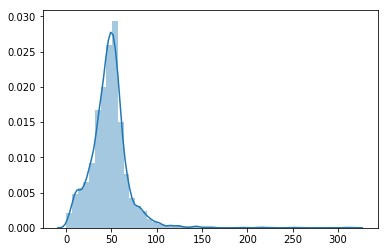

In [43]:
sns.distplot([len(i) for i in encoded_docs_test ])

In [44]:
train_len = 800

In [45]:
df_train_padded = padded_docs_combined
df_test_padded = padded_docs_combined_test

In [46]:
print(df_train_padded.shape)
print(df_test_padded.shape)

(1230, 100)
(4995, 100)


In [47]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'f1' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'f1' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('f1')
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.legend()
    plt.show()

In [48]:
X_train_text = df_train_padded
X_train_uid = train.iloc[:,10:]
y_train = pd.get_dummies(train.label)

X_test_text = df_test_padded
X_test_uid = test.iloc[:,9:]

In [49]:
X_test_uid.shape

(4995, 8)

In [50]:
"""
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], 
                  input_length=100, trainable=True)
model.add(e)
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(13, activation='softmax'))
"""

"\nmodel = Sequential()\ne = Embedding(vocab_size, 300, weights=[embedding_matrix], \n                  input_length=100, trainable=True)\nmodel.add(e)\nmodel.add(Conv1D(128, 3, activation='relu'))\nmodel.add(MaxPooling1D(3))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(MaxPooling1D(3))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv1D(64, 3, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Flatten())\nmodel.add(Dense(13, activation='softmax'))\n"

In [51]:

main_input = Input(shape=(100,), dtype='int32', name='main_input')

x = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=100, trainable=True)(main_input)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Conv1D(64, 3, activation='relu')(x)
#x = Dropout(0.5)(x)
conv_out = Flatten()(x)

auxiliary_input = Input(shape=(8,), name='aux_input')
x = keras.layers.concatenate([conv_out, auxiliary_input])

x = Dense(64, activation='relu')(x)
#x = Dense(64, activation='relu')(x)

main_output = Dense(13, activation='softmax')(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [52]:
# define function to calculate F1 score

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='categorical_crossentropy',
          optimizer= "adam",
          metrics=[f1])

In [53]:
# load saved model
#model = load_model('ubs_model.h5')

In [54]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     11861100    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 128)      115328      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 32, 128)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [55]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5)
history = model.fit([X_train_text, X_train_uid], y_train, validation_split=0.25,
                        epochs=100, verbose=1, callbacks=[es])

Train on 922 samples, validate on 308 samples
Epoch 1/100
922/922 [==============================] - 4s 4ms/step - loss: 2.1941 - f1: 0.0166 - val_loss: 1.8582 - val_f1: 0.0000e+00
Epoch 2/100
922/922 [==============================] - 1s 1ms/step - loss: 1.6884 - f1: 0.3000 - val_loss: 1.3536 - val_f1: 0.5109
Epoch 3/100
922/922 [==============================] - 1s 1ms/step - loss: 1.2368 - f1: 0.5566 - val_loss: 1.0354 - val_f1: 0.5904
Epoch 4/100
922/922 [==============================] - 1s 1ms/step - loss: 0.9301 - f1: 0.6412 - val_loss: 0.8901 - val_f1: 0.6466
Epoch 5/100
922/922 [==============================] - 1s 1ms/step - loss: 0.7255 - f1: 0.7208 - val_loss: 0.8836 - val_f1: 0.6204
Epoch 6/100
922/922 [==============================] - 1s 1ms/step - loss: 0.5626 - f1: 0.7842 - val_loss: 0.7417 - val_f1: 0.7059
Epoch 7/100
922/922 [==============================] - 1s 1ms/step - loss: 0.4426 - f1: 0.8375 - val_loss: 0.7916 - val_f1: 0.6886
Epoch 8/100
922/922 [============

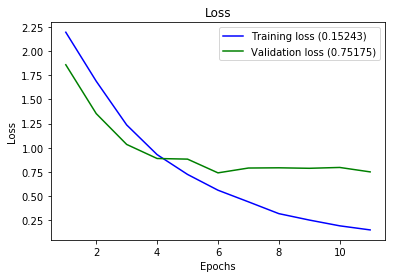

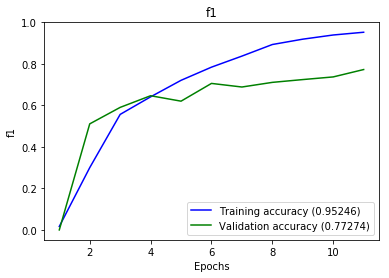

In [56]:
plot_history(history)

In [57]:
# save model as...
model.save('ubs_model.h5')  

In [58]:
y_pred = model.predict([X_test_text, X_test_uid])

In [59]:
np.argmax(y_pred, axis=1)

array([ 9,  9,  9, ..., 12,  8, 10], dtype=int64)

In [60]:
test['predict'] = np.argmax(y_pred, axis=1)

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
test.sample(10)[["clean_text","predict"]]

,clean_text,predict
4005,继年春季首次受游艺堂委托举办天风薪传游艺堂藏赵少昂书...,5
7632,警方通报北林大学生车祸事故原因肇事车涉嫌追逐竞驶话筒...,10
6049,海外拍场卢浮宫镇馆馆藏德拉克洛瓦名作自由引导人民唯一...,6
2915,税延养老保险来了月缴元岁后月领近月日起上海市福建省和...,8
2440,马自达在国内的主销当下只有和现在他们终于要引入海外版...,10
7088,家长注意别让你的孩子成为熊孩子围观围观围观在公共场合...,12
606,社交网站广告动力不足社交网站广告投放的市场价值正在下...,8
7547,教师资格证成绩查询听说教师资格证成绩可以查询了没有查...,10
2328,爱极客爱撩赛车北美漂移大师砖叔酷爱极客的秒拍视频,10
7262,小学放学早家长遇尴尬三点半难题怎么破思考小学减负三点...,12


In [62]:
test['user_id'].unique()

array([1497996114, 1628009324, 1881938674, 1895520105, 1988800805,
       2308351693, 2807239535, 5563089830], dtype=int64)

In [63]:
train['label'].value_counts()

10    320
9     238
8     216
0     102
5      66
6      62
1      55
12     46
4      44
11     34
7      26
2      11
3      10
Name: label, dtype: int64

In [64]:
# Car KOL
test[['clean_text','user_id','predict']][test['predict']==4]

,clean_text,user_id,predict
461,淘宝新规困局专题回顾淘宝商城近日调整招商规则技术服务...,1628009324,4
462,今日关注中国式人为的经济放缓中国上个季度的经济增速降...,1628009324,4
470,美国阿拉巴马州人口最为稠密的杰斐逊县政府日投票表决称...,1628009324,4
473,月出口回落中国海关周四公布月出口同比增略逊于预期值进...,1628009324,4
493,视频中国建筑制造业乃投资上选瑞银中国策略师约翰汤认为...,1628009324,4
506,英语视频中国政府积极预防经济过热麦格理私人财富部门主...,1628009324,4
517,视频中国经济增长放缓引市场担忧中国经济增长放缓引发市...,1628009324,4
527,图片房价上涨最快的二十国尽管世界经济不断引人担忧但是...,1628009324,4
533,视频港行或受益于人民币国际化今日中国推出人民币对买来...,1628009324,4
559,英文视频现阶段中国经济只能靠基础设施投资驱动新鸿基金...,1628009324,4


In [65]:
# Car KOL
test[['clean_text','user_id','predict']][test['user_id']==1895520105].shape[0]

348

In [66]:
# Car KOL pred
test[['clean_text','user_id','predict']][test['user_id']==1895520105][test['predict']==10].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


328

In [67]:
# Golf KOL
test[['clean_text','user_id','predict']][test['user_id']==1497996114].shape[0]

221

In [68]:
# Golf KOL pred
test[['clean_text','user_id','predict']][test['user_id']==1497996114][test['predict']==9].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


212

In [69]:
# Education KOL
test[['clean_text','user_id','predict']][test['user_id']==5563089830].shape[0]

1340

In [70]:
# Education KOL pred
test[['clean_text','user_id','predict']][test['user_id']==5563089830][test['predict']==11].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


188

In [71]:
# Education KOL pred
test[['clean_text','user_id','predict']][test['user_id']==5563089830][test['predict']==12].shape[0]

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


674

In [72]:
# Education KOL pred
test[['clean_text','user_id','predict']][test['predict']==3]

,clean_text,user_id,predict
522,经济美消费低迷恐至年底美国经济议会首席经济学家戈德斯...,1628009324,3
694,中国的新领导集体和改革高盛投资公司高级中国经济学家李...,1628009324,3
719,欧元集团主席法国需要加速改革上周六七国财长和央行官员...,1628009324,3
990,中国工业利润五月超预期大幅上升中国五月份工业利润数据...,1628009324,3
998,中国经济放缓印度成赢家世界第二大经济体中国经济放缓加...,1628009324,3
1131,中国正在保持经济平衡发展纽约大学斯特恩商学院经济学教...,1628009324,3
1160,中国可以实现真正的经济增长吗金融分析公司高级中国经济...,1628009324,3
1218,欧洲下一步面临什么欧洲工商管理学院经济学教授安东尼奥...,1628009324,3
1484,美国消费者已死库德洛报告显示去年月至今年月美国实际消...,1628009324,3
1487,访谈欧元区危机应迅速解决专访德意志银行约瑟夫阿科尔曼...,1628009324,3


In [73]:
output = test[['id','predict']]

In [74]:
output.to_csv('prediction.txt', header=False, index=False, sep="\t")

In [75]:
gc.collect()

0

In [106]:
comment = pd.read_json('UBS Weibo Data//weibo//Status_Data9_Comment_Data_with_city_code.json', encoding= 'UTF-8')
task = pd.read_json('UBS Weibo Data//weibo//task-status.json', encoding= 'UTF-8')
city = pd.read_json('UBS Weibo Data//weibo//weibo-china-province-city.json', encoding= 'UTF-8')

In [107]:
comment.head()

,cid,u_city,u_name,u_province,uid
0,G6RevbiBE,2,了不起的查尔斯,11,5048555731
1,G6RevbiBE,5,Pokerface1001,11,3211419333
2,G6RevbiBE,2,了不起的查尔斯,11,5048555731
3,G6QJ1aa2Z,3,飞马1515,44,5583941399
4,G9Ob5sz8r,1000,原来是酱紫的呀,400,5364706506


In [108]:
comment.shape

(17400, 5)

In [109]:
task.sample(10)

,comments_count,created_at,likes_count,retweets_count,s_text,sid,u_name,uid
1839,27,2018-02-20 12:15:00,87,138,:不了解人类货币史，就别拿数字货币乱吹牛不了解人类货...,G41AkmPXo,凤凰网财经,1988800805
4467,0,2018-03-01 13:43:00,23,8,:#2018春拍##香港蘇富比# 中国艺术品2018...,G5p0Plquu,蘇富比拍卖行,2308351693
3709,22,2018-04-06 03:49:00,11,20,:#车祸现场# 加西亚15号洞四次下水回顾。。。单洞...,GaOvpqMyC,新浪高尔夫,1497996114
2911,11,2018-03-12 23:02:00,26,11,:【马化腾建议的“进阶史”：数万字建议 涉及八大领域...,G78nbhs6O,凤凰网财经,1988800805
3720,18,2018-03-20 14:00:00,57,59,:【凤凰 夜读】李敖去世：这种能力，比你的出身和智商...,G8ieQDKnG,凤凰网财经,1988800805
3600,287,2018-04-03 11:31:00,63,1174,:抽奖啦！！！TaylorMade邀请您一同关注#美...,GapfEAblp,新浪高尔夫,1497996114
4222,0,2018-03-30 01:16:00,0,0,:#集智入微#去年秋季，爱普生发布了主题为“集智入微...,G9JvNamHS,凤凰网财经,1988800805
1683,5,2018-02-27 08:00:00,7,4,:【邓海清：监管对债市影响高峰已过 国债3.8以上闭...,G53UiuHfT,凤凰网财经,1988800805
2251,1,2018-03-14 23:54:00,9,2,:#少儿英语学习季#英文绘本阅读怎么启蒙？拼词训练你...,G7rz1u3jS,微博教育,5563089830
4497,14,2018-03-27 19:28:00,38,33,:#2018春拍##香港蘇富比#将呈献「钩沉帝宝——...,G9onNiaY0,蘇富比拍卖行,2308351693


In [110]:
task.head(5)

,comments_count,created_at,likes_count,retweets_count,s_text,sid,u_name,uid
0,20,2018-02-28 23:59:00,16,16,":【科技独角兽IPO""即报即审""？10大巨头万亿市值...",G5jCq7d7M,凤凰网财经,1988800805
1,10,2018-03-19 01:43:00,21,8,:宝骏530前一阵子刚刚公布了售价，并且外形采用了和...,G83Zh7dWB,爱极客,1895520105
2,63,2018-02-09 04:20:00,36,114,:【恒大打响2018房企大规模促销第一枪 全国楼盘8...,G2iM478Ip,凤凰网财经,1988800805
3,1,2018-04-07 05:40:00,11,2,:#美国大师赛#15号洞(没错，就是加西亚爆出+8那...,GaYEQ8hI3,新浪高尔夫,1497996114
4,31,2018-02-09 03:56:00,19,14,:【午评：权重跳水个股普跌 沪指重挫近6%后回升】受...,G2iCowAOT,凤凰网财经,1988800805


In [111]:
task['clean_text'] = task['s_text'].apply(clean)
uid_dum = pd.get_dummies(task.uid)
task = pd.merge(task,uid_dum, left_index=True, right_index=True)

In [112]:
X_task = []
for i in task.clean_text:
    X_task.append(rm_tokens([j for j in jieba.cut_for_search(i)]))
    
encoded_docs_task = t.texts_to_sequences(X_task)
padded_docs_combined_task = pad_sequences(encoded_docs_task, maxlen=100, padding='post')

In [113]:
X_task_text = padded_docs_combined_task
X_task_uid = task.iloc[:,9:]

In [115]:
for i in X_test_uid.columns:
    if i not in X_task_uid.columns:
        X_task_uid[i] = np.zeros(X_task_uid.shape[0])
        X_task_uid[i] = X_task_uid[i].apply(int).apply(str)

In [121]:
X_task_uid = X_task_uid.reindex_axis(sorted(X_test_uid.columns), axis=1)

C:\Users\edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [122]:
X_task_uid.head()

,1497996114,1628009324,1881938674,1895520105,1988800805,2308351693,2807239535,5563089830
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0


In [123]:
y_pred = model.predict([X_task_text, X_task_uid])

In [124]:
task['predict'] = np.argmax(y_pred, axis=1)

In [125]:
task.head()

,comments_count,created_at,likes_count,retweets_count,s_text,sid,u_name,uid,clean_text,1497996114,1895520105,1988800805,2308351693,2807239535,5563089830,predict
0,20,2018-02-28 23:59:00,16,16,":【科技独角兽IPO""即报即审""？10大巨头万亿市值...",G5jCq7d7M,凤凰网财经,1988800805,科技独角兽即报即审大巨头万亿市值待开发前有借壳今日正...,0,0,1,0,0,0,8
1,10,2018-03-19 01:43:00,21,8,:宝骏530前一阵子刚刚公布了售价，并且外形采用了和...,G83Zh7dWB,爱极客,1895520105,宝骏前一阵子刚刚公布了售价并且外形采用了和一样的家族...,0,1,0,0,0,0,10
2,63,2018-02-09 04:20:00,36,114,:【恒大打响2018房企大规模促销第一枪 全国楼盘8...,G2iM478Ip,凤凰网财经,1988800805,恒大打响房企大规模促销第一枪全国楼盘折优惠恒大已在房...,0,0,1,0,0,0,8
3,1,2018-04-07 05:40:00,11,2,:#美国大师赛#15号洞(没错，就是加西亚爆出+8那...,GaYEQ8hI3,新浪高尔夫,1497996114,美国大师赛号洞没错就是加西亚爆出那一洞马克利什曼成功...,1,0,0,0,0,0,9
4,31,2018-02-09 03:56:00,19,14,:【午评：权重跳水个股普跌 沪指重挫近6%后回升】受...,G2iCowAOT,凤凰网财经,1988800805,午评权重跳水个股普跌沪指重挫近后回升受海外股市低迷影...,0,0,1,0,0,0,0


In [130]:
output = task[['sid','predict']]
output.to_csv('prediction2.txt', header=False, index=False, sep="\t")

In [131]:
output.head()

,sid,predict
0,G5jCq7d7M,8
1,G83Zh7dWB,10
2,G2iM478Ip,8
3,GaYEQ8hI3,9
4,G2iCowAOT,0


In [133]:
output = task[['sid','predict','likes_count','retweets_count']]
output.to_csv('task.txt', header=False, index=False, sep="\t")

In [139]:
df = pd.read_csv('prediction.txt',header=None, sep='\t').append(pd.read_csv('prediction2.txt',header=None, sep='\t'), ignore_index=True)

In [141]:
df = df.drop_duplicates()

In [142]:
df.to_csv("final_prediction.txt", header=False, index=False, sep="\t")